In [1]:
IRT_DIMS = 0
DATASET = 'matrix'    
ITEM_FEATURES = 'True'
ITEM_FEATURES = False if ITEM_FEATURES == 'False' else True

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous, create_data_object_heterogeneous_temporal)
import seaborn as sns

from IRT import MIRT_2PL
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [36]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0.0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 2**14,
    'neighbours': [-1, -1]
#    'neighbours': [50, 50]
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0
    parameters['lambda2'] = 0
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [4, 8]
    OUTNAME = 'SAGE' 

if ITEM_FEATURES:
    OUTNAME = OUTNAME + '_scales'
    
print(parameters)
print(DATASET)

{'df_name': None, 'epochs': 10000, 'learning_rate': 0.005, 'weight_decay': 0.0, 'early_stopping': 200, 'n_splits': 10, 'device': 'cuda:0', 'batch_size': 16384, 'neighbours': [-1, -1], 'model_type': 'GNN', 'hidden_dims': [4, 8]}
matrix


In [5]:
range(1)

range(0, 1)

In [6]:
DATA_FILE = 'data/mindsteps_set_' + DATASET
df = load_data_heterogeneous(DATA_FILE)

In [7]:
if IRT_DIMS > 0:
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True, item_features=ITEM_FEATURES)
else:
    data, df_student, df_student_age, df_item, df_edge = create_data_object_heterogeneous_temporal(df, return_aux_data=True, item_features=ITEM_FEATURES)

In [8]:
print(data)

HeteroData(
  student={
    node_id=[636327],
    x=[636327, 4]
  },
  item={
    node_id=[17868],
    x=[17868, 11]
  },
  (student, responds, item)={
    edge_index=[2, 5613692],
    edge_attr=[5613692, 2],
    y=[5613692]
  },
  (item, rev_responds, student)={ edge_index=[2, 5613692] },
  (student, preceeds, student)={ edge_index=[2, 584819] }
)


%load_ext autoreload
%autoreload
from Heterogeneous_temporal_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
model = EmbedderHeterogeneous( 
    n_students = data['student'].node_id.size(0),
    n_items = data['item'].node_id.size(0),
    student_inchannel = data['student'].x.size(1),
    item_inchannel = data['item'].x.size(1),
    hidden_channels = parameters['hidden_dims'],
    edge_channel = 2,
    metadata = data.metadata()
    ).to(device)
#model(data)

optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
criterion = torch.nn.BCEWithLogitsLoss().to(device)#class_weights)
loss = []
for i in range(3000):
    l = train_embedder_heterogeneous(model, data, optimizer, criterion)
    loss.append(l)
    if i % 100 == 0:
        print(i, l)
        metrics = test_embedder_heterogeneous(model, data, 0, 'test')
        print(metrics)


train_losses = torch.Tensor(loss).detach().numpy()
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

In [ ]:
%load_ext autoreload
%autoreload
from manage_experiments import perform_cross_validation
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:00, ?it/s]

Parameters
{'n_students': 636327, 'n_items': 17868, 'student_inchannel': 4, 'item_inchannel': 11, 'hidden_channels': [4, 8], 'edge_channel': 2}
[4, 8]



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:31<01:11,  2.64s/it]

 31%|███       | 12/39 [00:43<01:11,  2.64s/it]

 64%|██████▍   | 25/39 [01:02<00:34,  2.46s/it]

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]



Epoch: 001, Loss: 0.4937, Val: 0.5512, Test: 0.5527



  0%|          | 1/10000 [01:32<258:06:24, 92.93s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:09,  2.56s/it]

 31%|███       | 12/39 [00:50<01:09,  2.56s/it]

 64%|██████▍   | 25/39 [01:02<00:35,  2.50s/it]

 64%|██████▍   | 25/39 [01:20<00:35,  2.50s/it]

100%|██████████| 39/39 [01:34<00:00,  2.42s/it]

  0%|          | 2/10000 [03:08<261:42:39, 94.23s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:00,  2.33s/it]

 33%|███▎      | 13/39 [00:45<01:00,  2.33s/it]

 69%|██████▉   | 27/39 [01:01<00:27,  2.28s/it]

100%|██████████| 39/39 [01:28<00:00,  2.28s/it]



Epoch: 003, Loss: 0.4282, Val: 0.5952, Test: 0.5967



  0%|          | 3/10000 [04:38<256:25:36, 92.34s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:01,  2.38s/it]

 33%|███▎      | 13/39 [00:45<01:01,  2.38s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.39s/it]

 67%|██████▋   | 26/39 [01:15<00:31,  2.39s/it]

100%|██████████| 39/39 [01:32<00:00,  2.38s/it]



Epoch: 004, Loss: 0.4141, Val: 0.6036, Test: 0.6046



  0%|          | 4/10000 [06:12<258:06:16, 92.95s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:00,  2.31s/it]

 33%|███▎      | 13/39 [00:41<01:00,  2.31s/it]

 62%|██████▏   | 24/39 [01:00<00:38,  2.54s/it]

 62%|██████▏   | 24/39 [01:11<00:38,  2.54s/it]

100%|██████████| 39/39 [01:33<00:00,  2.41s/it]



Epoch: 005, Loss: 0.4041, Val: 0.6062, Test: 0.6083



  0%|          | 5/10000 [07:47<260:10:44, 93.71s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:32<01:04,  2.49s/it]

 33%|███▎      | 13/39 [00:46<01:04,  2.49s/it]

 67%|██████▋   | 26/39 [01:03<00:31,  2.43s/it]

100%|██████████| 39/39 [01:32<00:00,  2.37s/it]



Epoch: 006, Loss: 0.3988, Val: 0.6085, Test: 0.6106



  0%|          | 6/10000 [09:20<260:09:20, 93.71s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:07,  2.51s/it]

 31%|███       | 12/39 [00:42<01:07,  2.51s/it]

 64%|██████▍   | 25/39 [01:02<00:34,  2.50s/it]

 64%|██████▍   | 25/39 [01:12<00:34,  2.50s/it]

100%|██████████| 39/39 [01:36<00:00,  2.47s/it]



Epoch: 007, Loss: 0.3967, Val: 0.6092, Test: 0.6107



  0%|          | 7/10000 [10:58<263:25:41, 94.90s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:00,  2.31s/it]

 33%|███▎      | 13/39 [00:45<01:00,  2.31s/it]

 64%|██████▍   | 25/39 [01:01<00:34,  2.47s/it]

 64%|██████▍   | 25/39 [01:15<00:34,  2.47s/it]

100%|██████████| 39/39 [01:31<00:00,  2.36s/it]



Epoch: 008, Loss: 0.3960, Val: 0.6092, Test: 0.6103



  0%|          | 8/10000 [12:31<261:45:24, 94.31s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:01,  2.35s/it]

 33%|███▎      | 13/39 [00:42<01:01,  2.35s/it]

 67%|██████▋   | 26/39 [01:01<00:30,  2.37s/it]

100%|██████████| 39/39 [01:31<00:00,  2.34s/it]



Epoch: 009, Loss: 0.3956, Val: 0.6103, Test: 0.6118



  0%|          | 9/10000 [14:03<260:06:21, 93.72s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:02,  2.41s/it]

 33%|███▎      | 13/39 [00:50<01:02,  2.41s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.42s/it]

100%|██████████| 39/39 [01:32<00:00,  2.38s/it]



Epoch: 010, Loss: 0.3954, Val: 0.6117, Test: 0.6137



  0%|          | 10/10000 [15:37<260:13:19, 93.77s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:32<01:04,  2.47s/it]

 33%|███▎      | 13/39 [00:46<01:04,  2.47s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.41s/it]

 67%|██████▋   | 26/39 [01:16<00:31,  2.41s/it]

100%|██████████| 39/39 [01:36<00:00,  2.47s/it]



Epoch: 011, Loss: 0.3951, Val: 0.6130, Test: 0.6149



  0%|          | 11/10000 [17:15<263:23:36, 94.93s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:01,  2.38s/it]

 33%|███▎      | 13/39 [00:48<01:01,  2.38s/it]

 67%|██████▋   | 26/39 [01:03<00:31,  2.44s/it]

 67%|██████▋   | 26/39 [01:18<00:31,  2.44s/it]

100%|██████████| 39/39 [01:33<00:00,  2.41s/it]



Epoch: 012, Loss: 0.3947, Val: 0.6141, Test: 0.6161



  0%|          | 12/10000 [18:50<263:27:02, 94.96s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.45s/it]

 33%|███▎      | 13/39 [00:43<01:03,  2.45s/it]

 67%|██████▋   | 26/39 [01:04<00:32,  2.47s/it]

100%|██████████| 39/39 [01:33<00:00,  2.41s/it]



Epoch: 013, Loss: 0.3944, Val: 0.6154, Test: 0.6170



  0%|          | 13/10000 [20:25<263:37:53, 95.03s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 18%|█▊        | 7/39 [00:32<02:30,  4.69s/it]

 18%|█▊        | 7/39 [00:48<02:30,  4.69s/it]

 33%|███▎      | 13/39 [01:04<02:10,  5.03s/it]

 33%|███▎      | 13/39 [01:18<02:10,  5.03s/it]

 49%|████▊     | 19/39 [01:41<01:50,  5.52s/it]

 49%|████▊     | 19/39 [01:58<01:50,  5.52s/it]

 72%|███████▏  | 28/39 [02:13<00:50,  4.56s/it]

100%|██████████| 39/39 [02:38<00:00,  4.07s/it]



Epoch: 014, Loss: 0.3941, Val: 0.6164, Test: 0.6179



  0%|          | 14/10000 [23:05<317:58:57, 114.63s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:02,  2.39s/it]

 33%|███▎      | 13/39 [00:48<01:02,  2.39s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.41s/it]

 67%|██████▋   | 26/39 [01:18<00:31,  2.41s/it]

100%|██████████| 39/39 [01:33<00:00,  2.39s/it]



Epoch: 015, Loss: 0.3938, Val: 0.6171, Test: 0.6185



  0%|          | 15/10000 [24:39<301:10:51, 108.59s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:07,  2.51s/it]

 31%|███       | 12/39 [00:44<01:07,  2.51s/it]

 64%|██████▍   | 25/39 [01:02<00:34,  2.49s/it]

 64%|██████▍   | 25/39 [01:14<00:34,  2.49s/it]

100%|██████████| 39/39 [01:34<00:00,  2.42s/it]



Epoch: 016, Loss: 0.3934, Val: 0.6176, Test: 0.6189



  0%|          | 16/10000 [26:15<290:11:21, 104.64s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:32<01:04,  2.47s/it]

 33%|███▎      | 13/39 [00:48<01:04,  2.47s/it]

 62%|██████▏   | 24/39 [01:02<00:39,  2.62s/it]

 62%|██████▏   | 24/39 [01:18<00:39,  2.62s/it]

100%|██████████| 39/39 [01:37<00:00,  2.50s/it]



Epoch: 017, Loss: 0.3930, Val: 0.6184, Test: 0.6194



  0%|          | 17/10000 [27:53<285:03:09, 102.79s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.46s/it]

 33%|███▎      | 13/39 [00:50<01:03,  2.46s/it]

 64%|██████▍   | 25/39 [01:02<00:35,  2.50s/it]

 64%|██████▍   | 25/39 [01:20<00:35,  2.50s/it]

100%|██████████| 39/39 [01:33<00:00,  2.40s/it]



Epoch: 018, Loss: 0.3926, Val: 0.6191, Test: 0.6201



  0%|          | 18/10000 [29:28<278:25:11, 100.41s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.44s/it]

 33%|███▎      | 13/39 [00:45<01:03,  2.44s/it]

 64%|██████▍   | 25/39 [01:03<00:35,  2.55s/it]

 64%|██████▍   | 25/39 [01:15<00:35,  2.55s/it]

100%|██████████| 39/39 [01:34<00:00,  2.43s/it]



Epoch: 019, Loss: 0.3921, Val: 0.6198, Test: 0.6211



  0%|          | 19/10000 [31:04<274:39:20, 99.06s/it] 

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:08,  2.53s/it]

 31%|███       | 12/39 [00:49<01:08,  2.53s/it]

 62%|██████▏   | 24/39 [01:00<00:38,  2.54s/it]

 62%|██████▏   | 24/39 [01:19<00:38,  2.54s/it]

100%|██████████| 39/39 [01:38<00:00,  2.53s/it]



Epoch: 020, Loss: 0.3916, Val: 0.6201, Test: 0.6215



  0%|          | 20/10000 [32:44<275:15:40, 99.29s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:08,  2.54s/it]

 31%|███       | 12/39 [00:49<01:08,  2.54s/it]

 64%|██████▍   | 25/39 [01:02<00:35,  2.50s/it]

 64%|██████▍   | 25/39 [01:19<00:35,  2.50s/it]

100%|██████████| 39/39 [01:36<00:00,  2.47s/it]

  0%|          | 21/10000 [34:21<273:15:35, 98.58s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.46s/it]

 33%|███▎      | 13/39 [00:42<01:03,  2.46s/it]

 67%|██████▋   | 26/39 [01:04<00:32,  2.47s/it]

 67%|██████▋   | 26/39 [01:22<00:32,  2.47s/it]

100%|██████████| 39/39 [01:35<00:00,  2.46s/it]

  0%|          | 22/10000 [35:57<271:28:04, 97.94s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:02,  2.39s/it]

 33%|███▎      | 13/39 [00:46<01:02,  2.39s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.39s/it]

 67%|██████▋   | 26/39 [01:16<00:31,  2.39s/it]

100%|██████████| 39/39 [0


Epoch: 023, Loss: 0.3897, Val: 0.6202, Test: 0.6218



  0%|          | 23/10000 [37:33<269:27:08, 97.23s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:32<01:05,  2.51s/it]

 33%|███▎      | 13/39 [00:50<01:05,  2.51s/it]

 64%|██████▍   | 25/39 [01:03<00:35,  2.55s/it]

 64%|██████▍   | 25/39 [01:20<00:35,  2.55s/it]

100%|██████████| 39/39 [01:37<00:00,  2.49s/it]

  0%|          | 24/10000 [39:11<269:59:47, 97.43s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:31<01:10,  2.61s/it]

 31%|███       | 12/39 [00:42<01:10,  2.61s/it]

 64%|██████▍   | 25/39 [01:03<00:35,  2.52s/it]

 64%|██████▍   | 25/39 [01:22<00:35,  2.52s/it]

100%|██████████| 39/39 [01:35<00:00,  2.46s/it]

  0%|          | 25/10000 [40:47<269:01:47, 97.09s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:08,  2.53s/it]

 31%|███       | 12/39 [00:46<01:08,  2.53s/it]

 64%|██████▍   | 25/39 [01:00<00:33,  2.40s/it]

 64%|██████▍   | 25/39 [01:16<00:33,  2.40s/it]

100%|██████████| 39/39 [0

 64%|██████▍   | 25/39 [01:02<00:34,  2.49s/it]

 64%|██████▍   | 25/39 [01:16<00:34,  2.49s/it]

100%|██████████| 39/39 [01:34<00:00,  2.42s/it]

  0%|          | 46/10000 [1:13:53<259:53:37, 93.99s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.46s/it]

 33%|███▎      | 13/39 [00:51<01:03,  2.46s/it]

 67%|██████▋   | 26/39 [01:03<00:31,  2.42s/it]

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]

  0%|          | 47/10000 [1:15:25<258:31:18, 93.51s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.45s/it]

 33%|███▎      | 13/39 [00:48<01:03,  2.45s/it]

 67%|██████▋   | 26/39 [01:03<00:31,  2.46s/it]

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]

  0%|          | 48/10000 [1:16:58<257:20:32, 93.09s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:08,  2.53s/it]

 31%|███       | 12/39 [00:46<01:08,  2.53s/it]

 64%|██████▍   | 25/39 [01:01<00:34,  2.46s/it]

 64%|██████▍   | 25/

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:02,  2.41s/it]

 33%|███▎      | 13/39 [00:50<01:02,  2.41s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.42s/it]

100%|██████████| 39/39 [01:31<00:00,  2.34s/it]

  1%|          | 69/10000 [1:50:07<259:56:45, 94.23s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:02,  2.39s/it]

 33%|███▎      | 13/39 [00:48<01:02,  2.39s/it]

 67%|██████▋   | 26/39 [01:01<00:30,  2.37s/it]

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]

  1%|          | 70/10000 [1:51:39<258:10:50, 93.60s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.44s/it]

 33%|███▎      | 13/39 [00:46<01:03,  2.44s/it]

 64%|██████▍   | 25/39 [01:02<00:34,  2.50s/it]

 64%|██████▍   | 25/39 [01:16<00:34,  2.50s/it]

100%|██████████| 39/39 [01:33<00:00,  2.41s/it]

  1%|          | 71/10000 [1:53:13<258:55:31, 93.88s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31

 33%|███▎      | 13/39 [00:48<01:01,  2.37s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.40s/it]

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]

  1%|          | 92/10000 [2:25:59<257:38:37, 93.61s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.42s/it]

 33%|███▎      | 13/39 [00:46<01:03,  2.42s/it]

 64%|██████▍   | 25/39 [01:01<00:34,  2.47s/it]

 64%|██████▍   | 25/39 [01:16<00:34,  2.47s/it]

100%|██████████| 39/39 [01:37<00:00,  2.51s/it]

  1%|          | 93/10000 [2:27:38<261:37:00, 95.07s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.44s/it]

 33%|███▎      | 13/39 [00:48<01:03,  2.44s/it]

 67%|██████▋   | 26/39 [01:04<00:32,  2.48s/it]

100%|██████████| 39/39 [01:33<00:00,  2.40s/it]

  1%|          | 94/10000 [2:29:12<261:07:31, 94.90s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:00,  2.34s/it]

 33%|███▎      | 13/39 [00:43<01:00,  2.34s/it]

 67%|██████▋   | 26/

 67%|██████▋   | 26/39 [01:02<00:31,  2.41s/it]

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]

  1%|          | 115/10000 [3:01:50<251:46:59, 91.70s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:01,  2.36s/it]

 33%|███▎      | 13/39 [00:46<01:01,  2.36s/it]

 67%|██████▋   | 26/39 [01:04<00:32,  2.49s/it]

 67%|██████▋   | 26/39 [01:16<00:32,  2.49s/it]

100%|██████████| 39/39 [01:34<00:00,  2.42s/it]

  1%|          | 116/10000 [3:03:25<254:30:35, 92.70s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:01,  2.36s/it]

 33%|███▎      | 13/39 [00:41<01:01,  2.36s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.40s/it]

100%|██████████| 39/39 [01:29<00:00,  2.31s/it]

  1%|          | 117/10000 [3:04:55<252:37:51, 92.02s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 36%|███▌      | 14/39 [00:32<00:58,  2.34s/it]

 36%|███▌      | 14/39 [00:50<00:58,  2.34s/it]

 69%|██████▉   | 27/39 [01:04<00:28,  2.41s/it]

100%|██████████| 

100%|██████████| 39/39 [01:35<00:00,  2.45s/it]

  1%|▏         | 137/10000 [3:36:21<260:36:15, 95.12s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:08,  2.53s/it]

 31%|███       | 12/39 [00:45<01:08,  2.53s/it]

 64%|██████▍   | 25/39 [01:00<00:33,  2.42s/it]

 64%|██████▍   | 25/39 [01:15<00:33,  2.42s/it]

100%|██████████| 39/39 [01:32<00:00,  2.37s/it]

  1%|▏         | 138/10000 [3:37:54<258:48:09, 94.47s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:31<01:09,  2.58s/it]

 31%|███       | 12/39 [00:42<01:09,  2.58s/it]

 64%|██████▍   | 25/39 [01:02<00:34,  2.49s/it]

 64%|██████▍   | 25/39 [01:12<00:34,  2.49s/it]

100%|██████████| 39/39 [01:33<00:00,  2.41s/it]

  1%|▏         | 139/10000 [3:39:28<258:43:15, 94.45s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.46s/it]

 33%|███▎      | 13/39 [00:48<01:03,  2.46s/it]

 67%|██████▋   | 26/39 [01:03<00:31,  2.45s/it]

 67%|██████▋   | 

 67%|██████▋   | 26/39 [01:02<00:31,  2.42s/it]

 67%|██████▋   | 26/39 [01:15<00:31,  2.42s/it]

100%|██████████| 39/39 [01:34<00:00,  2.42s/it]

  2%|▏         | 159/10000 [4:11:16<263:36:46, 96.43s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:32<01:05,  2.52s/it]

 33%|███▎      | 13/39 [00:50<01:05,  2.52s/it]

 67%|██████▋   | 26/39 [01:05<00:32,  2.52s/it]

100%|██████████| 39/39 [01:34<00:00,  2.43s/it]

  2%|▏         | 160/10000 [4:12:52<262:40:42, 96.10s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:30<01:00,  2.34s/it]

 33%|███▎      | 13/39 [00:45<01:00,  2.34s/it]

 64%|██████▍   | 25/39 [01:02<00:35,  2.54s/it]

 64%|██████▍   | 25/39 [01:15<00:35,  2.54s/it]

100%|██████████| 39/39 [01:35<00:00,  2.45s/it]

  2%|▏         | 161/10000 [4:14:28<262:48:02, 96.16s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:32<01:04,  2.47s/it]

 33%|███▎      | 13/39 [00:49<01:04,  2.47s/it]

 67%|██████▋   | 

  0%|          | 0/39 [00:00<?, ?it/s]

 31%|███       | 12/39 [00:30<01:08,  2.52s/it]

 31%|███       | 12/39 [00:43<01:08,  2.52s/it]

 64%|██████▍   | 25/39 [01:02<00:35,  2.51s/it]

 64%|██████▍   | 25/39 [01:13<00:35,  2.51s/it]

100%|██████████| 39/39 [01:36<00:00,  2.48s/it]

  2%|▏         | 182/10000 [4:47:32<260:07:44, 95.38s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:03,  2.46s/it]

 33%|███▎      | 13/39 [00:45<01:03,  2.46s/it]

 67%|██████▋   | 26/39 [01:02<00:31,  2.40s/it]

 67%|██████▋   | 26/39 [01:15<00:31,  2.40s/it]

100%|██████████| 39/39 [01:36<00:00,  2.47s/it]

  2%|▏         | 183/10000 [4:49:09<261:15:41, 95.81s/it]

  0%|          | 0/39 [00:00<?, ?it/s]

 33%|███▎      | 13/39 [00:31<01:02,  2.42s/it]

 33%|███▎      | 13/39 [00:48<01:02,  2.42s/it]

 64%|██████▍   | 25/39 [01:01<00:34,  2.48s/it]

 64%|██████▍   | 25/39 [01:18<00:34,  2.48s/it]

100%|██████████| 39/39 [01:34<00:00,  2.43s/it]

  2%|▏         | 184/10000 

In [25]:
output_dict.keys()
print('AUC:', output_dict['AUC_0_test'])
print('Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

AUC: 0.789598104610503
Balanced Accuracy: 0.7137387599972143


In [28]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [29]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data.cpu(), train_data.cpu(), val_data.cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_{DATASET}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}_{DATASET}.pth.tar')

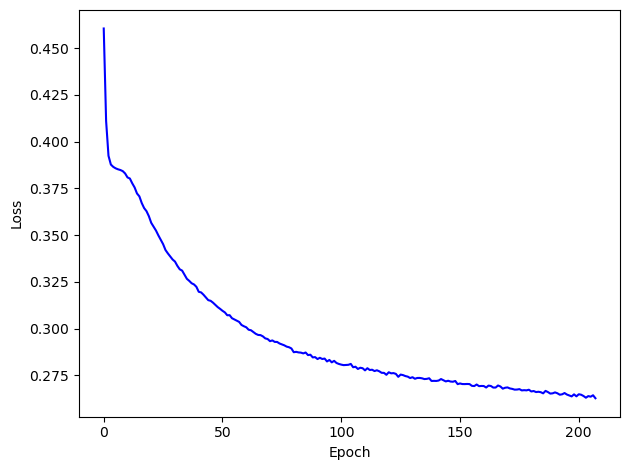

In [30]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

In [ ]:
# save IRT parameters to matrix
if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['offset']
    df_item['IRT1_discrimination'] = z_dict['discrimination']
    df_item['IRT1_discrimination_transf'] = z_dict['item']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data.cpu(), train_data.cpu(), val_data.cpu().cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_{DATASET}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    